In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

import torchvision.transforms as tfs
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize(0.5, 0.5)
])

In [3]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
labels = train_data['label']
train_data = train_data.drop(columns=["label"])
train_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


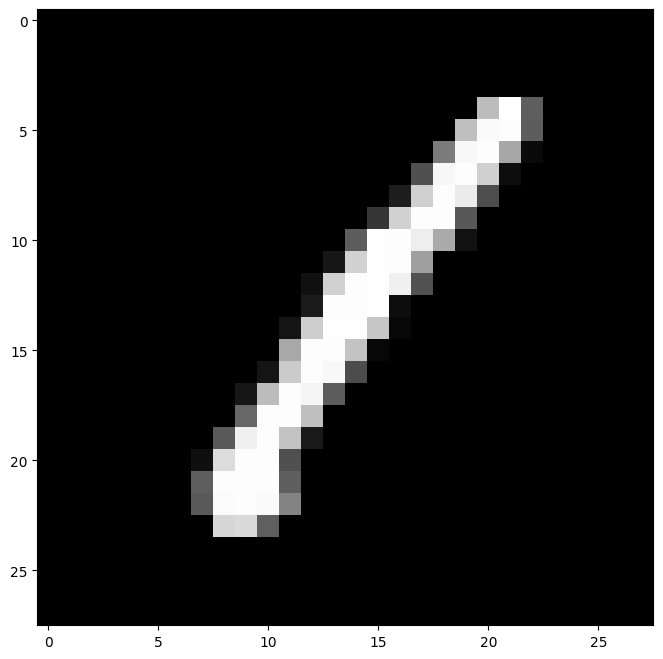

In [4]:
plt.figure(figsize=(8, 8))
plt.imshow(train_data.to_numpy()[0].reshape((28, 28)), cmap='gray')

In [5]:
class TrainDataset(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data, self.labels = data, labels
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        image = np.expand_dims((self.data[index].reshape(28, 28)), axis=-1)
        label = None
        
        if self.labels is not None:
            label = self.labels[index]
            
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    

In [6]:
train_dataset = TrainDataset(train_data.to_numpy().astype(np.float32), labels.to_numpy().astype(np.float32), transform=data_tfs)

train_size = int(len(train_data) * 0.8)
val_size = len(train_data) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, pin_memory=False)

loaders = {"train": train_loader, "valid": val_loader}

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
model = nn.Sequential(
    nn.Conv2d(1, 6, 3, padding=1), #28x28
    nn.ReLU(),
    nn.MaxPool2d(2), #14x14
    nn.Conv2d(6, 16, 3, padding=1), #14x14
    nn.ReLU(),
    nn.MaxPool2d(2), #7x7
    nn.Flatten(),
    nn.Linear(16 * 7 * 7, 480),
    nn.ReLU(),
    nn.Linear(480, 480),
    nn.ReLU(),
    nn.Linear(480, 10)
)

model.to(device)
fLoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
accurancy = {"train": [], "valid": []}
losses = {"train": [], "valid": []}

max_epochs = 10
for epoch in range(max_epochs):
    print(f'Epoch: {epoch + 1}')
    for k, dataloader in loaders.items():
        epoch_all = 0
        epoch_currect = 0
        epoch_loss = []
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.type(torch.LongTensor).to(device)
            if k == "train":
                model.train()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            
            loss = fLoss(outp, y_batch)
            epoch_loss.append(loss.detach().item())
            
            if k == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                    
            preds = outp.argmax(1)
            epoch_currect += (preds.flatten() == y_batch).type(torch.float32).sum().item()
            epoch_all += y_batch.shape[0]
            
        acc = epoch_currect/epoch_all
        loss = np.mean(epoch_loss)
        losses[k].append(loss)
        accurancy[k].append(acc)
        print(f'Loader: {k}, accuracy {acc}, loss: {loss}')

Epoch: 1
Loader: train, accuracy 0.9367857142857143, loss: 0.2704419681660476
Loader: valid, accuracy 0.973452380952381, loss: 0.08598389910449358
Epoch: 2
Loader: train, accuracy 0.9800595238095238, loss: 0.06417842014182713
Loader: valid, accuracy 0.979047619047619, loss: 0.07334966834980261
Epoch: 3
Loader: train, accuracy 0.9854464285714286, loss: 0.04474430169899105
Loader: valid, accuracy 0.9782142857142857, loss: 0.08227108868639775
Epoch: 4
Loader: train, accuracy 0.9880952380952381, loss: 0.03772637243916203
Loader: valid, accuracy 0.9755952380952381, loss: 0.09866860818036718
Epoch: 5
Loader: train, accuracy 0.9904761904761905, loss: 0.031168193998919812
Loader: valid, accuracy 0.9791666666666666, loss: 0.0908441021659228
Epoch: 6
Loader: train, accuracy 0.9900595238095238, loss: 0.03202231754023593
Loader: valid, accuracy 0.976547619047619, loss: 0.10297652956973197
Epoch: 7
Loader: train, accuracy 0.992827380952381, loss: 0.024806863972196534
Loader: valid, accuracy 0.97119

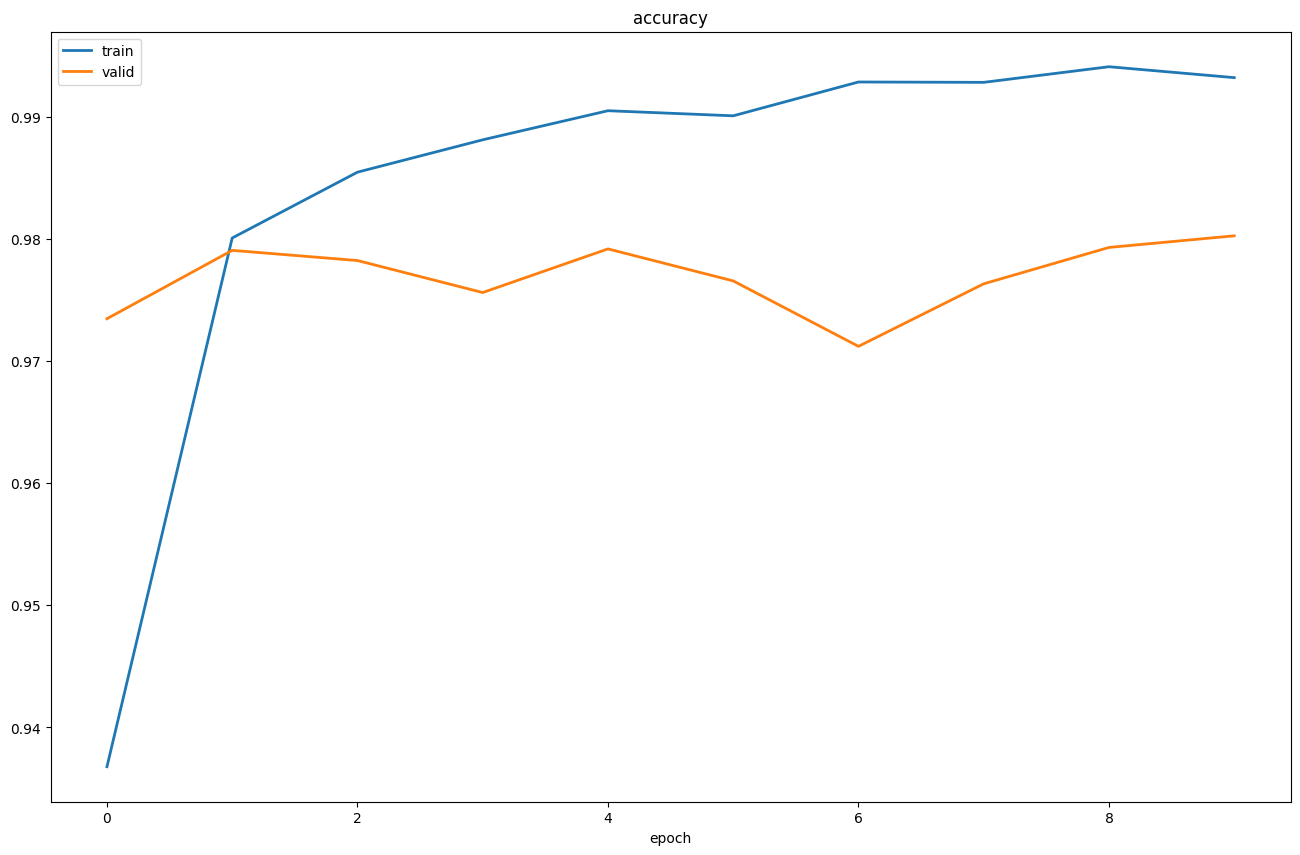

In [10]:
plt.figure(figsize=(16, 10))
plt.title("accuracy")
plt.plot(range(max_epochs), accurancy['train'], label='train', linewidth=2)
plt.plot(range(max_epochs), accurancy['valid'], label='valid', linewidth=2)
plt.legend()
plt.xlabel('epoch')
plt.show()

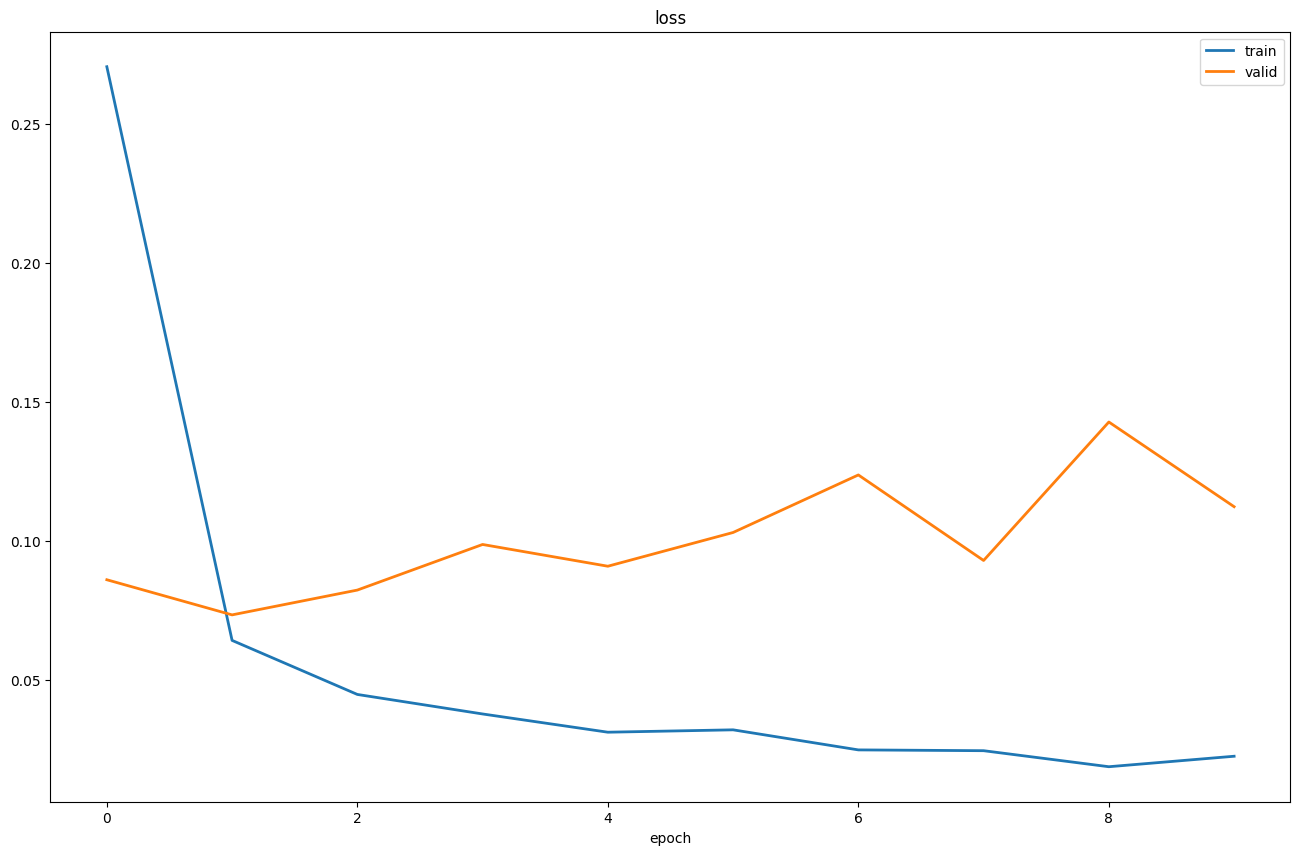

In [11]:
plt.figure(figsize=(16, 10))
plt.title("loss")
plt.plot(range(max_epochs), losses['train'], label='train', linewidth=2)
plt.plot(range(max_epochs), losses['valid'], label='valid', linewidth=2)
plt.legend()
plt.xlabel('epoch')
plt.show()

In [12]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
class TestDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        image = np.expand_dims((self.data[index].reshape(28, 28)), axis=-1)
            
        if self.transform is not None:
            image = self.transform(image)
            
        return image

In [14]:
test_dataset = TestDataset(test_data.to_numpy().astype(np.float32), transform=data_tfs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [15]:
result = []

model.eval()
for x_batch in test_loader:
    with torch.no_grad():
        outp = model(x_batch)
        preds = outp.argmax(1)
        result += preds.tolist()

In [16]:
submission = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [17]:
submission['Label'] = result
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [18]:
submission.to_csv("/kaggle/working/submission.csv", index=None)